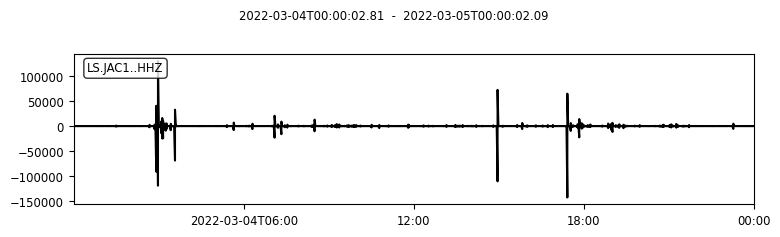

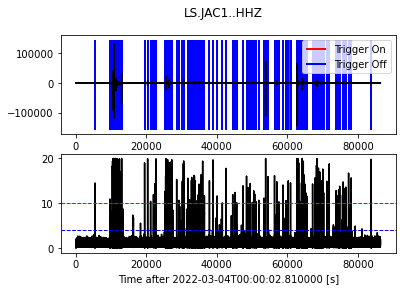

2022-03-04T01:30:03.790000Z


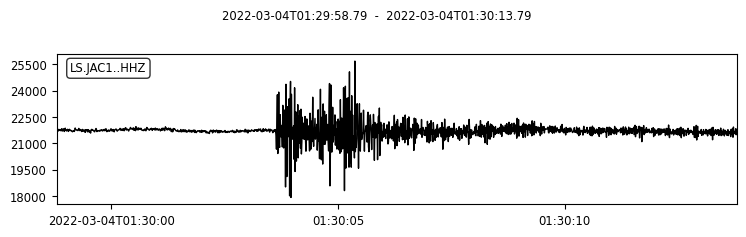

Digite S para gravar o evento.s
2022-03-04T02:40:30.100000Z


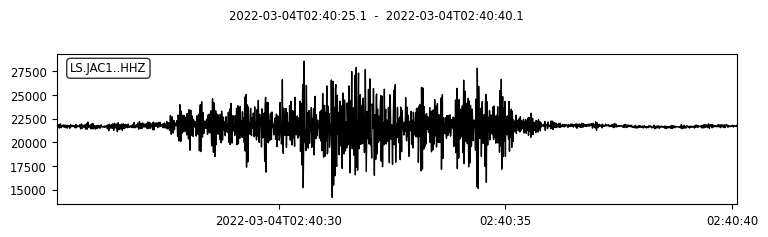

Digite S para gravar o evento.n
2022-03-04T02:52:21.000000Z


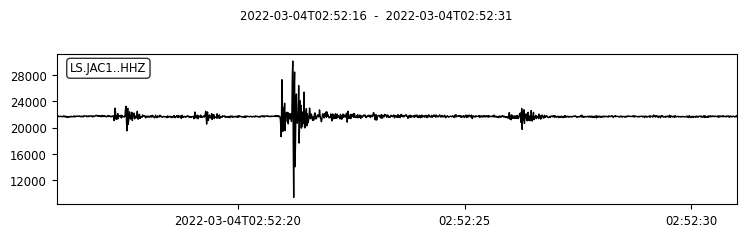

Digite S para gravar o evento.s
2022-03-04T02:52:48.000000Z


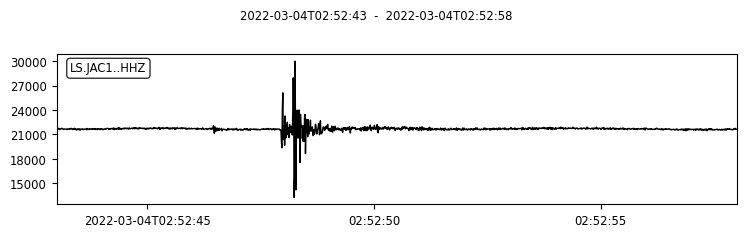

Digite S para gravar o evento.s
2022-03-04T02:54:32.570000Z


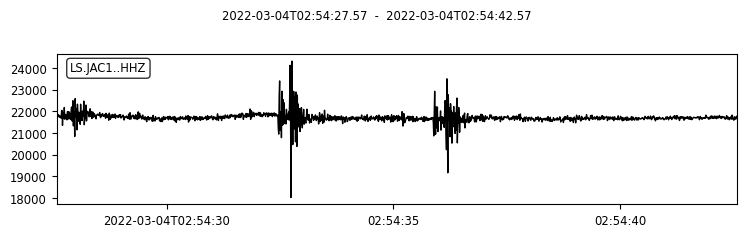

Digite S para gravar o evento.s
2022-03-04T02:55:17.020000Z


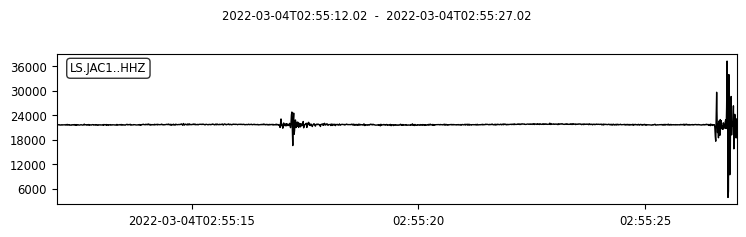

Digite S para gravar o evento.s
2022-03-04T02:55:26.600000Z


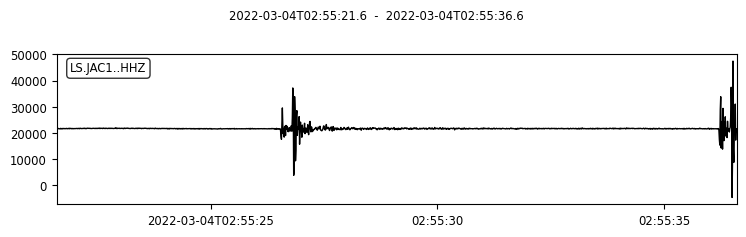

Digite S para gravar o evento.s
2022-03-04T02:55:36.600000Z


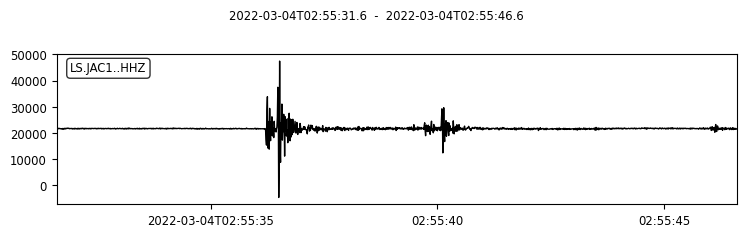

Digite S para gravar o evento.s
2022-03-04T02:55:50.130000Z


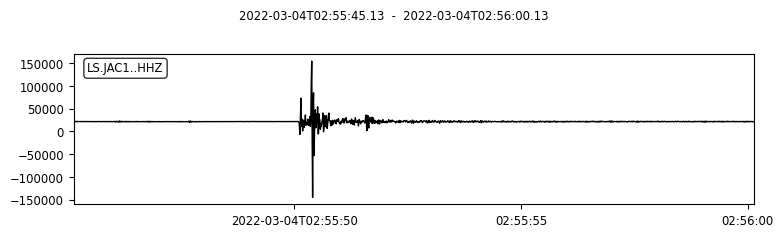

Digite S para gravar o evento.s
2022-03-04T02:56:19.820000Z


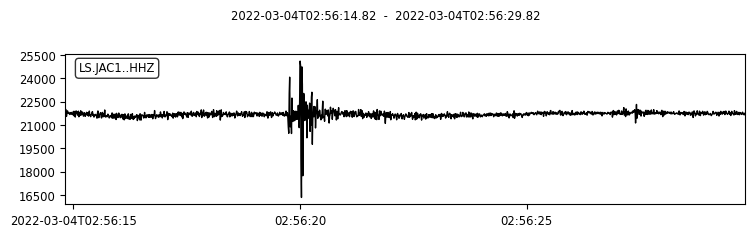

Digite S para gravar o evento.s
2022-03-04T02:56:55.670000Z


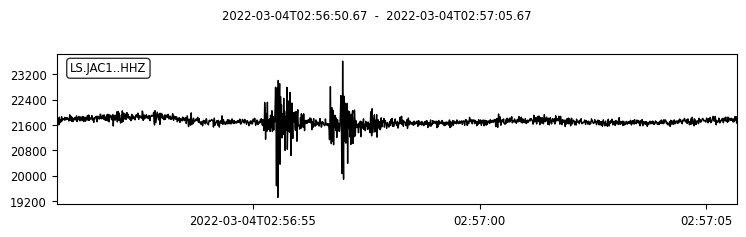

Digite S para gravar o evento.s
2022-03-04T02:57:35.810000Z


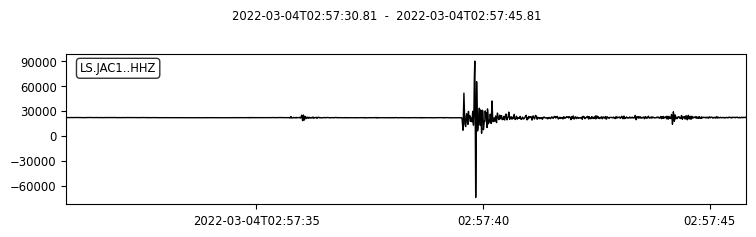

Digite S para gravar o evento.s
2022-03-04T02:57:39.570000Z


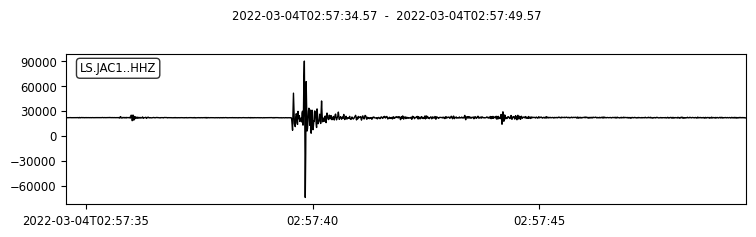

Digite S para gravar o evento.s
2022-03-04T02:58:58.440000Z


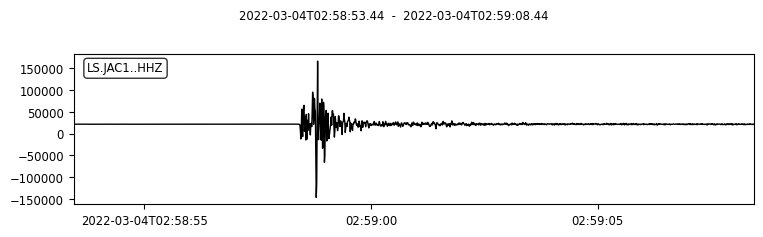

Digite S para gravar o evento.s
2022-03-04T02:59:55.340000Z


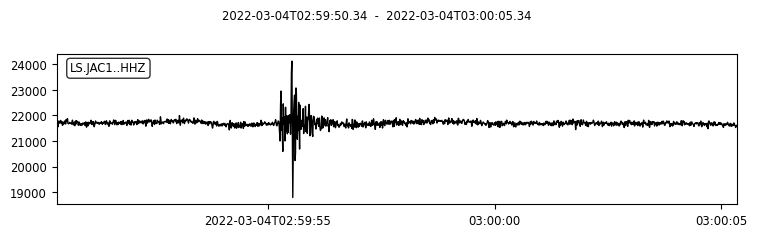

Digite S para gravar o evento.s
2022-03-04T03:02:36.710000Z


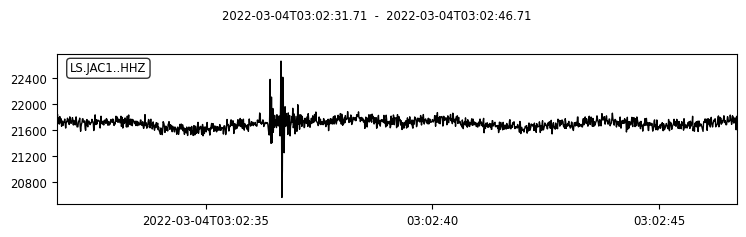

Digite S para gravar o evento.s
2022-03-04T03:03:01.940000Z


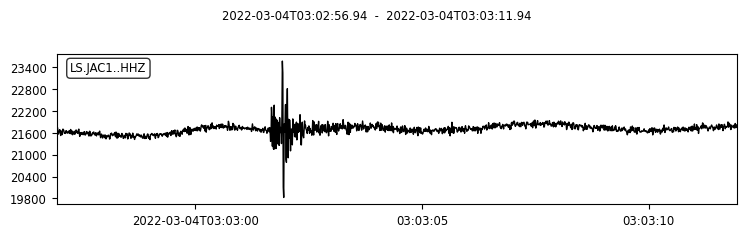

Digite S para gravar o evento.s
2022-03-04T03:03:17.930000Z


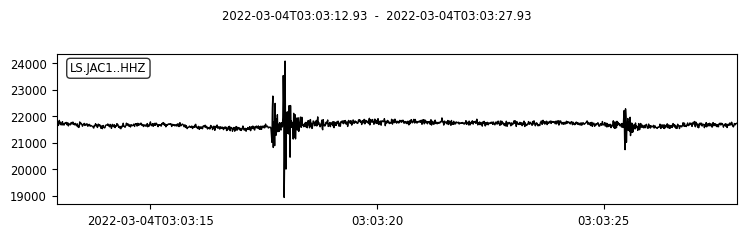

Digite S para gravar o evento.s
2022-03-04T03:06:20.530000Z


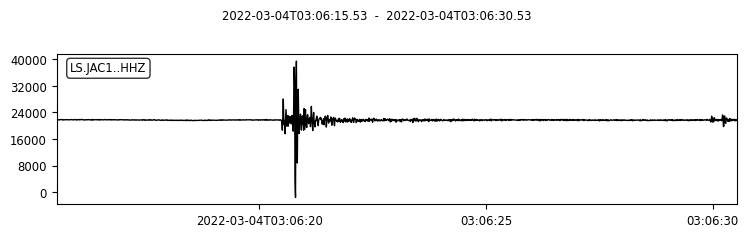

Digite S para gravar o evento.s
2022-03-04T03:07:29.580000Z


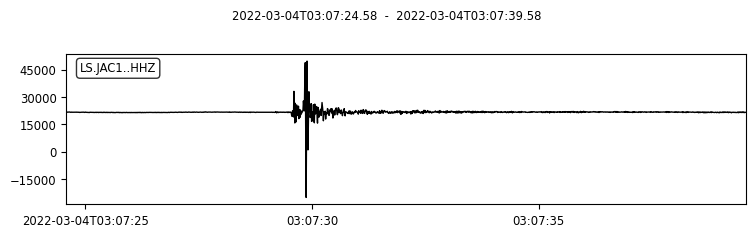

Digite S para gravar o evento.s
2022-03-04T03:08:24.270000Z


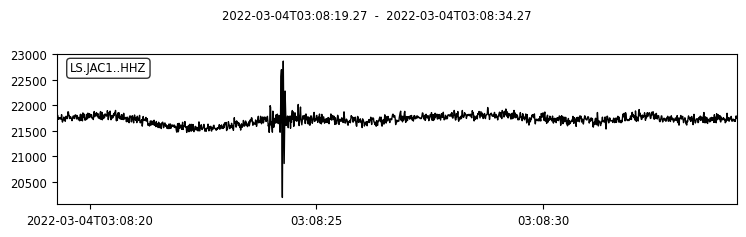

Digite S para gravar o evento.s
2022-03-04T03:09:05.110000Z


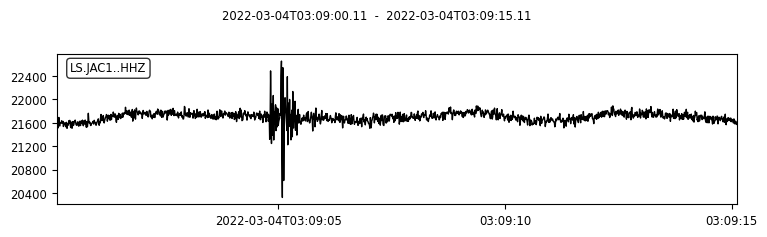

Digite S para gravar o evento.s
2022-03-04T03:09:59.170000Z


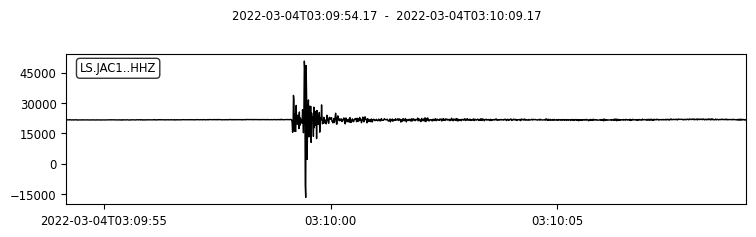

Digite S para gravar o evento.s
2022-03-04T03:11:01.490000Z


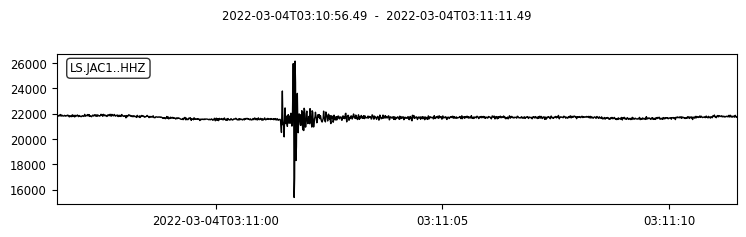

Digite S para gravar o evento.s
2022-03-04T03:15:11.700000Z


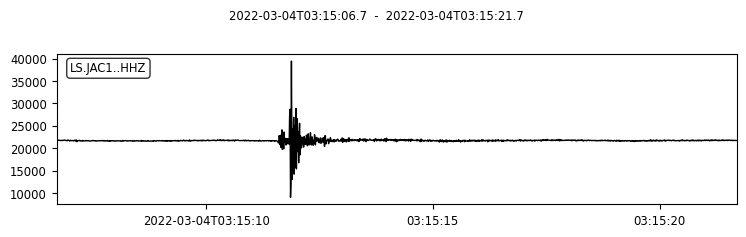

KeyboardInterrupt: Interrupted by user

In [2]:
from obspy.core import Stream, read
from obspy.signal.trigger import coincidence_trigger
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import plot_trigger, trigger_onset

from pprint import pprint
import glob
import os
import sys

# Pasta com os possíveis eventos recortados 
path = "../eventos/"

if not os.path.exists(path):
        os.mkdir(path)

trigger_on = 5 # o código utiliza  
trigger_off = 2
sta = 0.5
lta = 10

############################################################
# Dia juliano
j = "063"

# Caminho para os Dados
#dados = "/home/felipe/sources/DADOS/seiscomp_NRT/2022/"
dados = "../DADOS/2022/"

# Rede e estações
rede = ['LS']
estacoes = ['JAC1']
############################################################

st = Stream()
files = []
for r in rede:
    files = files + glob.glob(dados + r + "/*/*HHZ*/*" + j)

for f in files:
    for e in estacoes:
        if(e in f):
            tr = read(f)
            if(len(tr) > 0):
                tr.merge(fill_value='interpolate')
            st += tr
            
tr = st[0].copy()
df = tr.stats.sampling_rate
if(df > 100):
    tr.decimate(4)
    df = tr.stats.sampling_rate

tr.detrend()
tr.filter('bandpass', freqmin=2, freqmax=20)

#trig = coincidence_trigger("recstalta", trigger_on, trigger_off, st2, 2, sta=sta, lta=lta,
#                          details=True)
#pprint(trig)

tr.plot()

cft = classic_sta_lta(tr.data, int(sta * df), int(lta * df))

if(max(cft) > 2*trigger_on):
    trigger_on = max(cft)/2
    trigger_off = max(cft)/5

plot_trigger(tr, cft, trigger_on, trigger_off)

trig = []
triggers = trigger_onset(cft, trigger_on, trigger_off)
for trigger in triggers:
    trig.append({'time':tr.stats.starttime + (trigger[0] / df),'stations':[estacoes[0]]})
    
    
for d in trig:
    start = d['time'] - 5
    end = start + 15
    
    pasta = path + j
    if not os.path.exists(pasta):
        os.mkdir(pasta)
        
    for s in d['stations']:
        print(d['time'])
        for f in files:
            if (s in f):
                st = read(f)
                tr = st.copy()
                tr.trim(start, end)
                #tr.filter('bandpass', freqmin=2, freqmax=20)
                tr.plot()
                text = input("Digite S para gravar o evento.") 
                if(text == "S" or text == "s" or text == "y" or text == "Y"):
                    pasta = path + j + "/" + str(d['time'])
                    if not os.path.exists(pasta):
                        os.mkdir(pasta)
                    tr.write(pasta + "/" + str(s) + ".HHZ", format='SAC')
                    ff = f.replace('HHZ','HHN')
                    st = read(ff)
                    tr = st.copy()
                    tr.trim(start, end)
                    tr.write(pasta + "/"+str(s)+".HHN", format='SAC')
                    ff = f.replace('HHZ','HHE')
                    ff.replace('HHN','HHE')
                    st = read(ff)
                    tr = st.copy()
                    tr.trim(start, end)
                    tr.write(pasta + "/" + str(s)+".HHE", format='SAC')
                if(text == "q" or text == "Q"):
                    sys.exit()
                
                
                #tr.plot()